# ACNets: Connectivity Classifier

This notebook fits a binary classifier to predict participant's group, AVGP or NVGP, using Cognitive Control network connectivity matrices. As input, it receives upper-triangular connectivity matrices for each participant. Results are evaluated using 5-fold cross-validated f1 on the train set.

## Setup

In [3]:

import numpy as np
import xarray as xr
import pandas as pd

from IPython.display import clear_output
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import plotly.express as px

from sklearn import preprocessing, model_selection, metrics, ensemble, multioutput
from sklearn import decomposition, cross_decomposition, feature_selection, dummy, svm

from sklearn.pipeline import Pipeline
# from xgboost import XGBClassifier  # incompatible with umap's scipy

sns.set(style='dark')

# Technical reproducibility
%reload_ext watermark
%watermark -iv -co -ituhmv

Last updated: 2022-02-15T15:49:37.979536+01:00

Python implementation: CPython
Python version       : 3.9.10
IPython version      : 8.0.1

conda environment: acnets

Compiler    : Clang 11.1.0 
OS          : Darwin
Release     : 21.3.0
Machine     : x86_64
Processor   : i386
CPU cores   : 12
Architecture: 64bit

Hostname: MP0159

pandas    : 1.4.0
matplotlib: 3.5.1
numpy     : 1.21.5
xarray    : 0.21.1
plotly    : 5.5.0
sys       : 3.9.10 | packaged by conda-forge | (main, Feb  1 2022, 21:28:27) 
[Clang 11.1.0 ]
sklearn   : 1.0.2
seaborn   : 0.11.2



### Load the data

In [6]:
atlases = ['dosenbach2007', 'difumo_64_2', 'difumo_128_2', 'difumo_1024_2']


DATASETS = dict()

for atlas in atlases:
  DATASETS[atlas] = xr.open_dataset(f'data/julia2018_resting/connectivity_{atlas}.nc')

# selected data for the analysis
ATLAS = 'difumo_64_2'
DATASET = DATASETS[ATLAS]
CONNECTIVITY = DATASET['tangent_connectivity'].values

## Input/output data

In [8]:
# 1. input (vectorized connectivity matrix)
X = np.array([subj_conn[np.triu_indices_from(subj_conn, k=1)] for subj_conn in CONNECTIVITY])

# 2. output (AVGP or NVGP)
group_encoder = preprocessing.LabelEncoder()
y = group_encoder.fit_transform(DATASET['group'])

# 3. behavioral outputs (inverse efficiency scores in millis)
y_beh = DATASET['inverse_efficiency_score_ms'].values

# 4. remove subjects with missing behavioral data
X = X[~np.isnan(y_beh)]
y = y[~np.isnan(y_beh)]
y_beh = y_beh[~np.isnan(y_beh)]

## Test/train split

In [22]:
train, test = model_selection.train_test_split(
  range(len(X)),
  test_size=0.2,
  shuffle=True,
  stratify=y)

## Classification pipeline

In [81]:
# ALT1: boosting (replicate https://www.frontiersin.org/articles/10.3389/fnhum.2014.00425/full)
model = svm.SVC(kernel='rbf', C=1)
# model =ensemble.AdaBoostClassifier(model, n_estimators=100, algorithm='SAMME')

from sklearn import linear_model

# ALT2: chance level
# model = dummy.DummyClassifier(strategy='uniform')

# ALT3: multi-output (classification + behavioral regression)
# model = multioutput.MultiOutputClassifier(ensemble.GradientBoostingClassifier())


pipeline = Pipeline([
    ('zerovar', feature_selection.VarianceThreshold()),
    # ('select', feature_selection.SelectKBest()),
    # ('rfe', feature_selection.RFE(linear_model.RidgeClassifier())),
    # ('standard_scaler', preprocessing.StandardScaler()), 
    # ('reducer', UMAP(n_components=3)), 
    # ('reducer', decomposition.PCA()),
    # ('reducer', cross_decomposition.PLSCanonical()),    
    ('model', model),
    # ('model', linear_model.RidgeClassifier())
], verbose=True)


param_grid = {
    # 'zerovar__threshold': [0],
    # 'select__k': np.linspace(1, X.shape[1], num=100, endpoint=True, dtype='int'),
    # 'rfe__n_features_to_select': [.1, .2, .5, 1.],
    # 'reducer__n_neighbors': [1, 2, 3, 4, 5, 10],  # UMAP
    # 'reducer__n_components': [2,3,5],  # UMAP
    # 'reducer__n_components': range(1, 30),  # PCA
    # 'model__n_estimators': [10, 100, 1000],  # XGBClassifier, GradientBoostingClassifier
    # 'model__estimator__n_estimators': [10, 100],  # MultiOutputClassifier
}

grid = model_selection.GridSearchCV(
    pipeline, param_grid,
    cv=model_selection.LeaveOneOut(),
    scoring='accuracy',
    # scoring=['accuracy', 'roc_auc', 'f1', 'precision', 'recall'], refit='accuracy',
    n_jobs=1, verbose=1,
)

# rfe_model = feature_selection.RFECV(grid)
# rfe_model.fit()


grid.fit(X[train], y[train])

score_train = grid.score(X[train], y[train])
score_test = grid.score(X[test], y[test])

score_test = model_selection.cross_val_score(grid, X, y, cv=5)

clear_output(wait=True)

# report scores and hyperparameters
print(f'Train set score (roc_auc): {score_train:.2f}')
print(f'Test set score (cross-validated roc_auc):', score_test.mean())

Train set score (roc_auc): 1.00
Test set score (cross-validated roc_auc): 0.5047619047619047


## Model performance
Below is the confusion matrix of the classifier on the train and test sets.

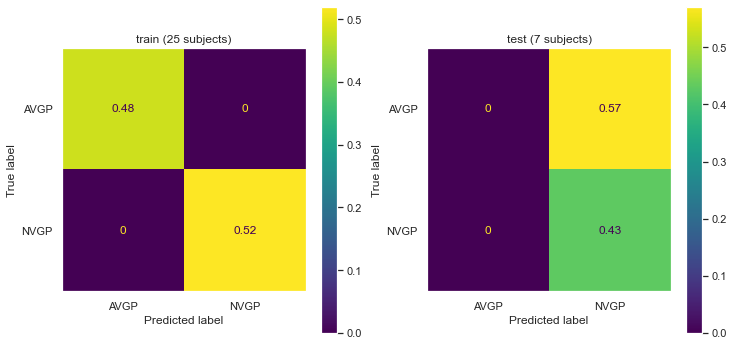

In [82]:
# plot confusion matrix
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# train set
metrics.ConfusionMatrixDisplay.from_estimator(
  grid,
  X[train], y[train],
  normalize='all',
  display_labels=group_encoder.classes_,
  ax=axes[0],
  )

# test set
metrics.ConfusionMatrixDisplay.from_estimator(
  grid,
  X[test], y[test],
  normalize='all',
  display_labels=group_encoder.classes_,
  ax=axes[1],
  )

# set titles
axes[0].set(title=f'train ({len(train)} subjects)')
axes[1].set(title=f'test ({len(test)} subjects)')

plt.show()